# Error Analysis on the Classification Results

In [10]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
import os
import re
import json
from typing import List
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.metrics import confusion_matrix
from helpers.helpersParsingResults import parse_ground_truth_and_predictions, import_HIPE_results, parse_model_results, get_global_sent_metrics, plot_results

In [11]:
PRED_DIR = "./../../data/results/"
TRUE_DIR = "./../../data/release/2/"

TRUE_FILES = {"de": {"dev": "de/newsagency-data-2-dev-de.tsv", 
                     "test": "de/newsagency-data-2-test-de.tsv"},
              "fr": {"dev": "fr/newsagency-data-2-dev-fr.tsv", 
                     "test": "fr/newsagency-data-2-test-fr.tsv"}
}

PRED_FILES = {
    "de": {"dev": "newsagency-data-2-dev-de_pred.tsv", 
           "test": "newsagency-data-2-test-de_pred.tsv"},
    "fr": {"dev": "newsagency-data-2-dev-fr_pred.tsv", 
           "test": "newsagency-data-2-test-fr_pred.tsv"}
}

### Get Best Run per Model

In [12]:
def get_all_best_model_runs(models_dir, set="test"):
    df_best = pd.DataFrame()

    all_ne_global_metrics, _, _, _, _ = parse_model_results(models_dir)
    df = all_ne_global_metrics[all_ne_global_metrics["set"]==set]

    df["name"] = df["model"] + "_" + df["max_sequence_length"].astype(str) + "_" + df["language"] + "_" + set
    df["lang"] = df["language"].apply(lambda x: "multilingual" if "multi" in x else x)
    df["modelname"] = "model_" + df["model"] + "_max_sequence_length_" + df["max_sequence_length"].astype(str) + "_epochs_3_run_" + df["lang"] + "_" + df["run"].astype(str)
    for name in df["name"].unique():
        df_sel = df[df["name"] == name].reset_index()
        max_id = df_sel["f1"].idxmax()
        df_best = pd.concat([df_best, df_sel.iloc[[max_id]]])
    
    return df_best

def get_best_run(df_best, name):
    best_run = df_best[df_best["name"]==name][["run", "modelname"]]
    return best_run["modelname"].values[0] #, best_run["run"].values[0]

In [13]:
df_best = get_all_best_model_runs(PRED_DIR)
df_best.head()

,index,model,max_sequence_length,epochs,suffix,set,language,run,loss,precision,recall,f1,name,lang,modelname
2,5,bert_base_cased,128,3,_run_de_3,test,de,3,0.090681,0.862745,0.862745,0.862745,bert_base_cased_128_de_test,de,model_bert_base_cased_max_sequence_length_128_...
0,11,bert_base_cased,128,3,_run_fr_1,test,fr,1,0.067083,0.763158,0.758170,0.760656,bert_base_cased_128_fr_test,fr,model_bert_base_cased_max_sequence_length_128_...
1,25,bert_base_cased,128,3,_run_multilingual-de_2,test,multilingual-de,2,0.096218,0.860000,0.843137,0.851485,bert_base_cased_128_multilingual-de_test,multilingual,model_bert_base_cased_max_sequence_length_128_...
1,27,bert_base_cased,128,3,_run_multilingual-fr_2,test,multilingual-fr,2,0.064931,0.792208,0.797386,0.794788,bert_base_cased_128_multilingual-fr_test,multilingual,model_bert_base_cased_max_sequence_length_128_...
4,49,bert_base_cased,256,3,_run_de_5,test,de,5,0.064677,0.900000,0.849057,0.873786,bert_base_cased_256_de_test,de,model_bert_base_cased_max_sequence_length_256_...


In [151]:
get_best_run(df_best, "bert_base_german_cased_128_de_test")

'model_bert_base_german_cased_max_sequence_length_128_epochs_3_run_de_2'

In [155]:
get_best_run(df_best, "dbmdz_bert_base_french_europeana_cased_128_fr_test")

'model_dbmdz_bert_base_french_europeana_cased_max_sequence_length_128_epochs_3_run_fr_5'

## Parse Prediction and Ground Truth File

In [118]:
def parse_tsv_gt_and_prediction(model_dir: str, set="dev", lang="de",
                                true_dir = TRUE_DIR, true_files=TRUE_FILES, pred_dir=PRED_DIR, pred_files=PRED_FILES):
    #get ground truth
    true_file = os.path.join(true_dir, true_files[lang][set])
    with open(true_file, "r") as f:
        true_lines = [line for line in f]

    #get predictions
    pred_file = os.path.join(pred_dir, model_dir, pred_files[lang][set])
    with open(pred_file, "r") as f:
        pred_lines = [line for line in f]

    return parse_ground_truth_and_predictions(pred_lines, true_lines)

In [119]:
models_to_import = [
    "bert_base_cased_128_de_test",
    "bert_base_cased_256_de_test",
    "bert_base_cased_512_de_test",
    "bert_base_german_cased_128_de_test",
    "bert_base_german_cased_256_de_test",
    "bert_base_german_cased_512_de_test",

    "bert_base_cased_128_fr_test",
    "bert_base_cased_256_fr_test",
    "bert_base_cased_512_fr_test",
    "dbmdz_bert_base_french_europeana_cased_128_fr_test",
    "dbmdz_bert_base_french_europeana_cased_256_fr_test",
    "dbmdz_bert_base_french_europeana_cased_512_fr_test"
]

imported_models = {}
for model in models_to_import:
    if ("_de" in model) or ("-de" in model):
        imported_models[model] = parse_tsv_gt_and_prediction(get_best_run(df_best, model), "test", "de")
    elif ("_fr" in model) or ("-fr" in model):
        imported_models[model] = parse_tsv_gt_and_prediction(get_best_run(df_best, model), "test", "fr")
    else:
        print("Could not infer language from model name", model)

In [120]:
imported_models["bert_base_cased_128_de_test"].head()

,token,pred_ag,true_ag,pos_in_doc,len_doc,LED,is_correct_class,at_beginning,at_end,in_middle
0,Ünjtefi,O,UP-UPI,23.0,1225.0,0.33,False,False,False,True
1,Preß,O,UP-UPI,24.0,1225.0,0.33,False,False,False,True
2,Exchange,Extel,Extel,459.0,1225.0,0.00,True,False,False,True
3,DNB,DNB,DNB,536.0,1225.0,0.00,True,False,False,True
4,ag,ag,ag,672.0,1225.0,0.00,True,False,False,True


## Confusion Matrix

In [139]:
def plot_confusion_matrix(df, title, make_plot=False, ax=None):
    true_labels = list(df["true_ag"].unique())
    labels = true_labels + [label for label in list(df["pred_ag"].unique()) if not label in true_labels]
    labels = [entry for entry in labels if not entry == "O"] + ["O"]
    cf_matrix = confusion_matrix(df["true_ag"], df["pred_ag"], labels=labels)

    #plotting
    if not ax:
        fig, ax = plt.subplots(figsize=(12, 8))
    s = sns.heatmap(cf_matrix, xticklabels=labels, yticklabels=labels, annot=True, ax=ax, cmap="rocket_r")
    s.set(xlabel='Predicted Label', ylabel='True Label')
    ax.set_title(title)

    if make_plot:
        plt.show()

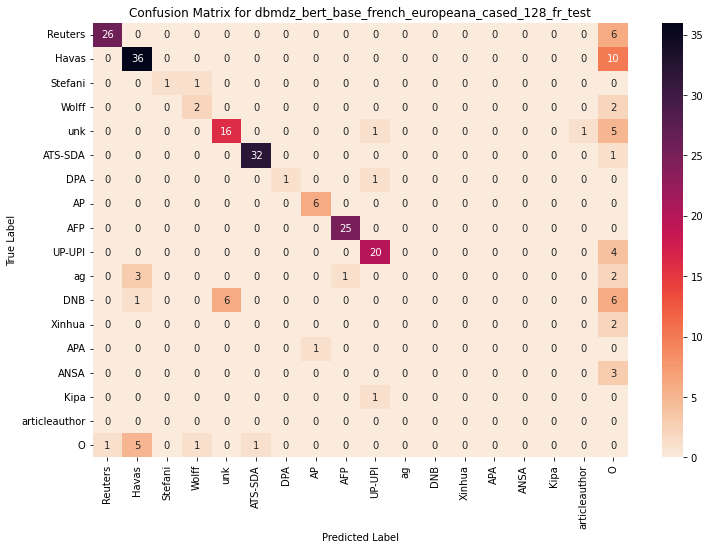

In [140]:
plot_confusion_matrix(imported_models["dbmdz_bert_base_french_europeana_cased_128_fr_test"], "Confusion Matrix for dbmdz_bert_base_french_europeana_cased_128_fr_test")

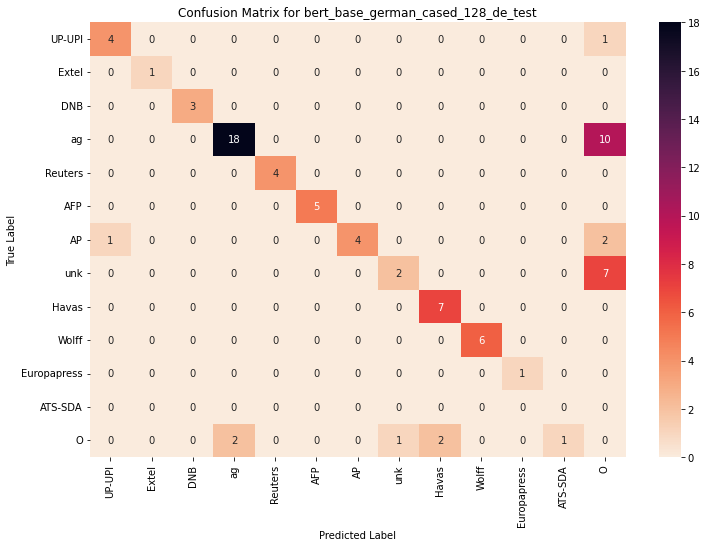

In [125]:
plot_confusion_matrix(imported_models["bert_base_german_cased_128_de_test"], "Confusion Matrix for bert_base_german_cased_128_de_test")

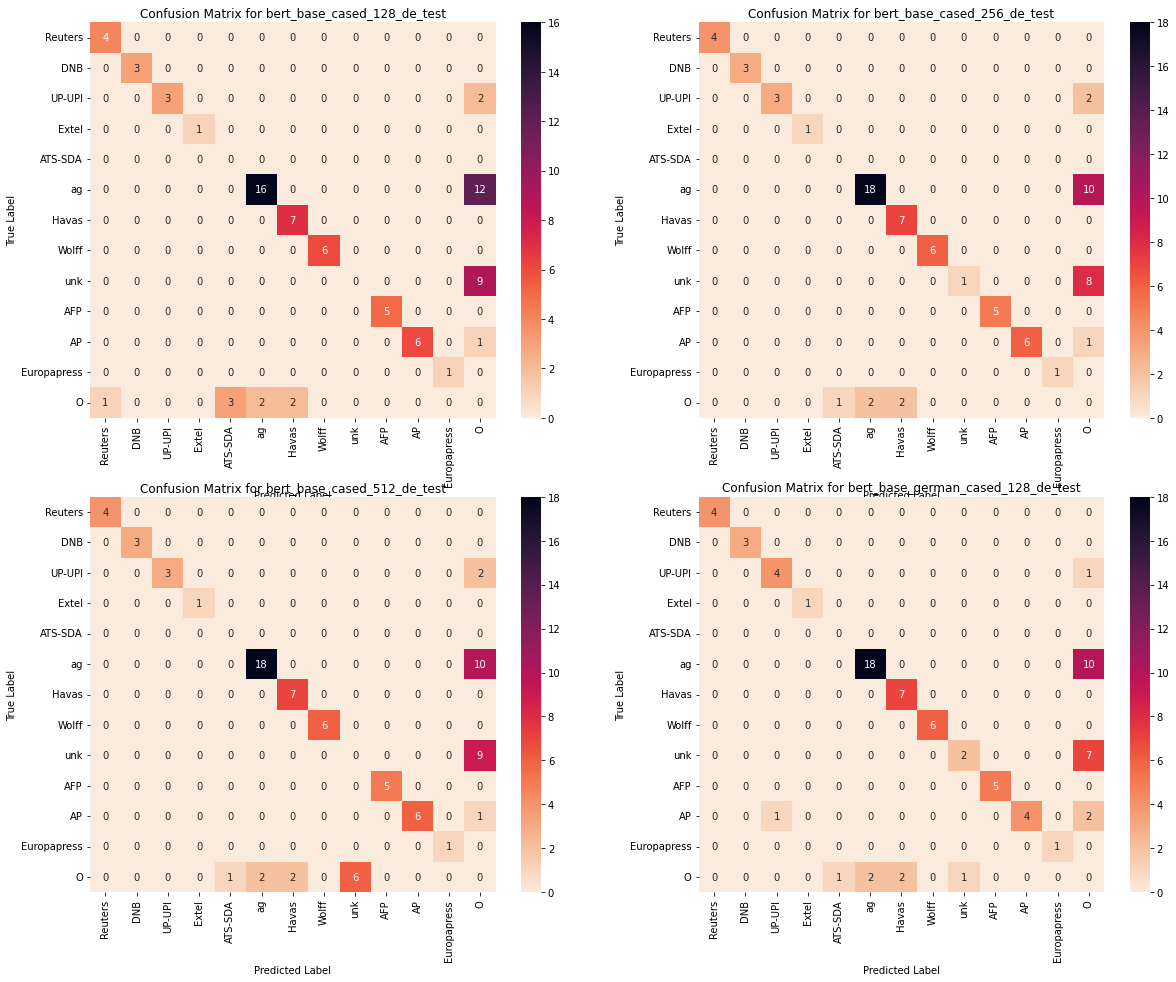

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(20, 16))

for (i,j), model in zip([(0,0), (0,1), (1,0), (1,1)], list(imported_models.keys())[:4]):
    plot_confusion_matrix(imported_models[model], f"Confusion Matrix for {model}", ax=axs[i,j])

## Positions of Agencies

In [126]:
def get_correct_ratio_per_pos(df, pos="at_beginning"):
   df_all = df[(df["pred_ag"] != "O") & df[pos] ]
   df_correct = df_all[df_all["is_correct_class"]]
   # avoid division by 0
   if len(df_all) == 0:
      return None
   else:
      return round(len(df_correct)/len(df_all)*100, 2)

def get_correct_ratios(df):
   percs = {}
   percs["at_beginning"] = get_correct_ratio_per_pos(df, "at_beginning")
   percs["in_middle"] = get_correct_ratio_per_pos(df, "in_middle")
   percs["at_end"] = get_correct_ratio_per_pos(df, "at_end")
   return percs

In [127]:
def get_all_df_pos(imported_models):
    positions_dict = {
        "model": [],
        "at_beginning": [],
        "in_middle": [],
        "at_end": []
    }
    for model, model_df in imported_models.items():
        percs = get_correct_ratios(model_df)
        positions_dict["model"].append(model)
        positions_dict["at_beginning"].append(percs["at_beginning"])
        positions_dict["in_middle"].append(percs["in_middle"])
        positions_dict["at_end"].append(percs["at_end"])

    df_pos = pd.DataFrame(positions_dict)
    return df_pos
df_pos = get_all_df_pos(imported_models)
df_pos.head()

,model,at_beginning,in_middle,at_end
0,bert_base_cased_128_de_test,100.0,85.96,NaN
1,bert_base_cased_256_de_test,100.0,91.23,NaN
2,bert_base_cased_512_de_test,100.0,82.26,NaN
3,bert_base_german_cased_128_de_test,100.0,88.14,NaN
4,bert_base_german_cased_256_de_test,100.0,89.09,NaN


[]

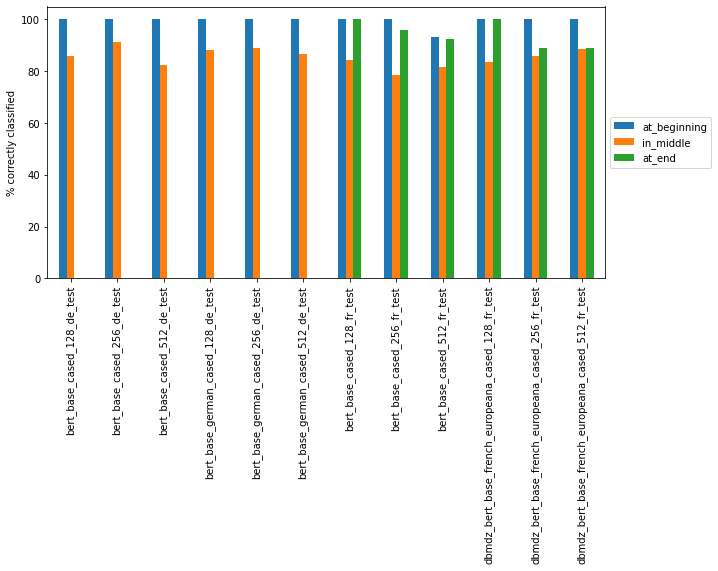

In [129]:
fig, ax = plt.subplots(figsize=(10, 5))
df_pos.plot.bar(ax=ax)
ax.set_xticklabels(df_pos["model"])
ax.set_ylabel("% correctly classified")
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.plot()

## OCR Noise

In [ ]:
def get_correct_ratio_per_noise(df):
    df_equal_0 = df[(df["pred_ag"] != "O") & 
               df["LED"] == 0 ]
    df_bigger_0 = df[(df["pred_ag"] != "O") & 
               df["LED"] > 0 ]
    df_equal_0_correct = df_equal_0[df_equal_0["is_correct_class"]]
    df_bigger_0_correct = df_bigger_0[df_bigger_0["is_correct_class"]]

    len_equal = len(df_equal_0)
    len_bigger = len(df_bigger_0)

    return {
        "LED == 0": (round(len(df_equal_0_correct)/len_equal *100, 2), len_equal) if len_equal > 0 else None,
        "LED > 0": (round(len(df_bigger_0_correct)/len_bigger *100, 2), len_bigger) if len_bigger > 0 else None,
    }

In [ ]:
for model, model_df in imported_models.items():
    print(f"{model} - % of correctly predicted news agencies:\n{get_correct_ratio_per_noise(model_df)}\n")

bert_base_cased_128_de_test - % of correctly predicted news agencies:
{'LED == 0': (61.45, 83), 'LED > 0': (100.0, 1)}

bert_base_cased_256_de_test - % of correctly predicted news agencies:
{'LED == 0': (67.5, 80), 'LED > 0': (100.0, 1)}

bert_base_cased_512_de_test - % of correctly predicted news agencies:
{'LED == 0': (61.63, 86), 'LED > 0': (100.0, 1)}

bert_base_german_cased_128_de_test - % of correctly predicted news agencies:
{'LED == 0': (66.25, 80), 'LED > 0': (100.0, 2)}

bert_base_german_cased_256_de_test - % of correctly predicted news agencies:
{'LED == 0': (63.75, 80), 'LED > 0': (100.0, 1)}

bert_base_german_cased_512_de_test - % of correctly predicted news agencies:
{'LED == 0': (74.39, 82), 'LED > 0': (50.0, 2)}

bert_base_cased_128_fr_test - % of correctly predicted news agencies:
{'LED == 0': (70.87, 230), 'LED > 0': (100.0, 5)}

bert_base_cased_256_fr_test - % of correctly predicted news agencies:
{'LED == 0': (67.38, 233), 'LED > 0': (100.0, 5)}

bert_base_cased_512

#### HIPE Data

In [ ]:
NOISE_LEVELS = ["LED-0.0-0.0", "LED-0.001-0.1", "LED-0.1-0.3", "LED-0.3-1.1"]
TIME_LEVELS = ["TIME-1800-1900", "TIME-1900-1940", "TIME-1940-2000"]

In [ ]:
noise_dev_HIPE = import_HIPE_results(noise_levels=NOISE_LEVELS, suffix="_time_noise", metrics=["F1_micro", "F1_macro_doc", "TP", "FN"], results_dir="../data/results/")
grouped_noise_dev_HIPE = noise_dev_HIPE.groupby(["model", "language", "max_sequence_length", "noise_level"]).agg(
    {"run": "count", 
     "F1_micro": [np.mean, np.std],
     "F1_macro_doc": [np.mean, np.std],
     "TP": "sum", "FN": "sum"}
     ).reset_index()
grouped_noise_dev_HIPE.head()

model language max_sequence_length    noise_level   run  \
                                                               count   
0  bert_base_cased       de                  64    LED-0.0-0.0     5   
1  bert_base_cased       de                  64  LED-0.001-0.1     5   
2  bert_base_cased       de                  64    LED-0.1-0.3     5   
3  bert_base_cased       de                  64    LED-0.3-1.1     5   
4  bert_base_cased       de                 128    LED-0.0-0.0     5   

   F1_micro           F1_macro_doc            TP  FN  
       mean       std         mean       std sum sum  
0  0.715568  0.067859     0.928593  0.037733  70  20  
1  0.000000  0.000000          NaN       NaN   0   0  
2  0.000000  0.000000          NaN       NaN   0   5  
3  0.177778  0.205631     1.000000  0.000000   3   2  
4  0.747895  0.031765     0.934074  0.019059  74  16

In [ ]:
noise_test_HIPE = import_HIPE_results(noise_levels=NOISE_LEVELS, suffix="_time_noise", metrics=["F1_micro", "F1_macro_doc", "TP", "FN"], results_dir="../data/results/", set="test")
grouped_noise_test_HIPE = noise_test_HIPE.groupby(["model", "language", "max_sequence_length", "noise_level"]).agg(
    {"run": "count", 
     "F1_micro": [np.mean, np.std],
     "F1_macro_doc": [np.mean, np.std],
     "TP": "sum", "FN": "sum"}
     ).reset_index()
grouped_noise_test_HIPE.tail()

model         language max_sequence_length    noise_level  \
                                                                            
315  xlm_roberta_base  multilingual-fr                 256    LED-0.3-1.1   
316  xlm_roberta_base  multilingual-fr                 512    LED-0.0-0.0   
317  xlm_roberta_base  multilingual-fr                 512  LED-0.001-0.1   
318  xlm_roberta_base  multilingual-fr                 512    LED-0.1-0.3   
319  xlm_roberta_base  multilingual-fr                 512    LED-0.3-1.1   

      run  F1_micro          F1_macro_doc             TP   FN  
    count      mean      std         mean       std  sum  sum  
315     5  0.000000  0.00000     0.000000  0.000000    0   20  
316     5  0.238686  0.12733     0.346085  0.105621  128  447  
317     5  0.000000  0.00000          NaN       NaN    0    0  
318     5  0.000000  0.00000     0.000000  0.000000    0   35  
319     5  0.000000  0.00000     0.000000  0.000000    0   20

In [ ]:
df_noise = grouped_noise_test_HIPE.dropna()
df_noise = df_noise.groupby(["model", "language", "noise_level"]).agg(np.mean).reset_index()
df_noise.columns = df_noise.columns.map("".join)
df_noise = df_noise.rename(columns={"F1_micromean": "F1_micro_mean"})[["model", "language", "noise_level", "F1_micro_mean"]]
df_noise["name"] = df_noise["model"] + "_" + df_noise["language"]
df_noise_de = df_noise[df_noise["language"].isin(["de", "multilingual-de"])].pivot(index="noise_level", columns="name", values="F1_micro_mean")
df_noise_fr = df_noise[df_noise["language"].isin(["fr", "multilingual-fr"])].pivot(index="noise_level", columns="name", values="F1_micro_mean")
df_noise_de.head()

C:\Users\Lea\AppData\Local\Temp/ipykernel_20244/137834855.py:2: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df_noise = df_noise.groupby(["model", "language", "noise_level"]).agg(np.mean).reset_index()


name,bert_base_cased_de,bert_base_cased_multilingual-de,bert_base_german_cased_de,bert_base_multilingual_cased_de,bert_base_multilingual_cased_multilingual-de,dbmdz_bert_base_german_europeana_cased_de,dbmdz_bert_base_historic_multilingual_cased_de,dbmdz_bert_base_historic_multilingual_cased_multilingual-de,xlm_roberta_base_de,xlm_roberta_base_multilingual-de
noise_level,,,,,,,,,,
LED-0.0-0.0,0.798868,0.788263,0.798724,0.279212,0.606304,0.570362,0.347332,0.679414,0.623419,0.599638
LED-0.1-0.3,0.225779,0.191923,0.233922,0.044444,0.055230,0.104523,NaN,0.063182,0.244502,0.106115


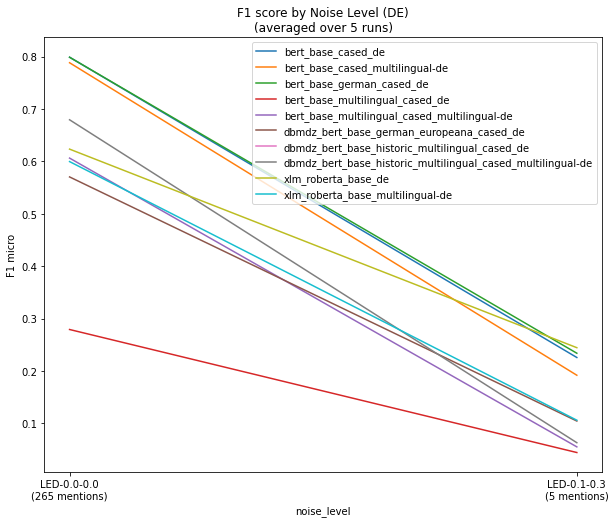

In [ ]:
f = plt.figure(figsize=(10,8))

plt.title('F1 score by Noise Level (DE)\n(averaged over 5 runs)', color='black')
ax = df_noise_de.plot(kind='line', ax=f.gca())
ax.legend()#loc='center left', bbox_to_anchor=(1.0, 0.5))
ax.set_xticks([0,1])
xlabels = [f"{df_noise_de.index[0]}\n(265 mentions)", f"{df_noise_de.index[1]}\n(5 mentions)"]
ax.set_xticklabels(xlabels)
ax.set_ylabel("F1 micro")
plt.show()

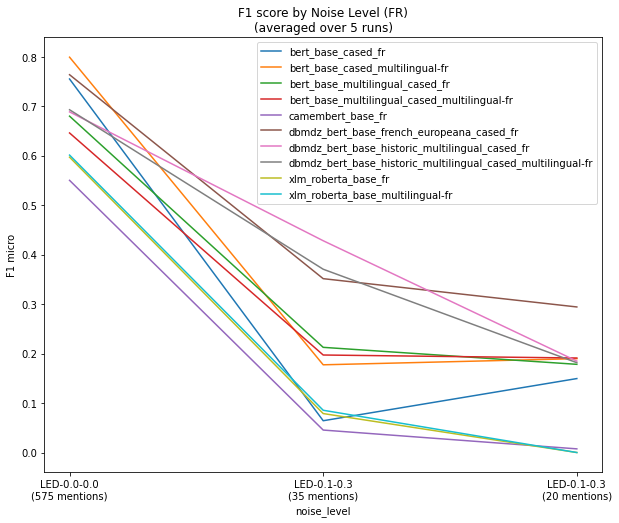

In [ ]:
f = plt.figure(figsize=(10,8))

plt.title('F1 score by Noise Level (FR)\n(averaged over 5 runs)', color='black')
ax = df_noise_fr.plot(kind='line', ax=f.gca())
ax.legend()#loc='center left', bbox_to_anchor=(1.0, 0.5))
ax.set_xticks([0,1,2])
xlabels = [f"{df_noise_de.index[0]}\n(575 mentions)", f"{df_noise_de.index[1]}\n(35 mentions)", f"{df_noise_de.index[1]}\n(20 mentions)"]
ax.set_xticklabels(xlabels)
ax.set_ylabel("F1 micro")
plt.show()

## Swapped Agencies

In [ ]:
ne_global_metrics, ne_dev_metrics, ne_test_metrics,  sent_dev_metrics, sent_test_metrics = parse_model_results("./../data/experiments_newag/")

Was not able to get results for model: model_bert_base_multilingual_cased_max_sequence_length_256_epochs_3_run_multilingual_4


In [ ]:
ne_test = ne_global_metrics.loc[(ne_global_metrics["set"]=="test") &
                                    ne_global_metrics["run"].notna()]
grouped_ne_test = ne_test.groupby(["model", "language", "max_sequence_length"]).agg({"run": "count", 
                                                                                   "f1": [np.mean, np.std],
                                                                                   "precision": [np.mean, np.std],
                                                                                   "recall": [np.mean, np.std]}).reset_index()

c:\Users\Lea\Documents\Uni Aachen\5. Semester\Master Thesis\own-code\notebooks\helpersParsingResults.py:441: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(n_x, rotation=0, rotation_mode='anchor', ha="center") #rotation=75


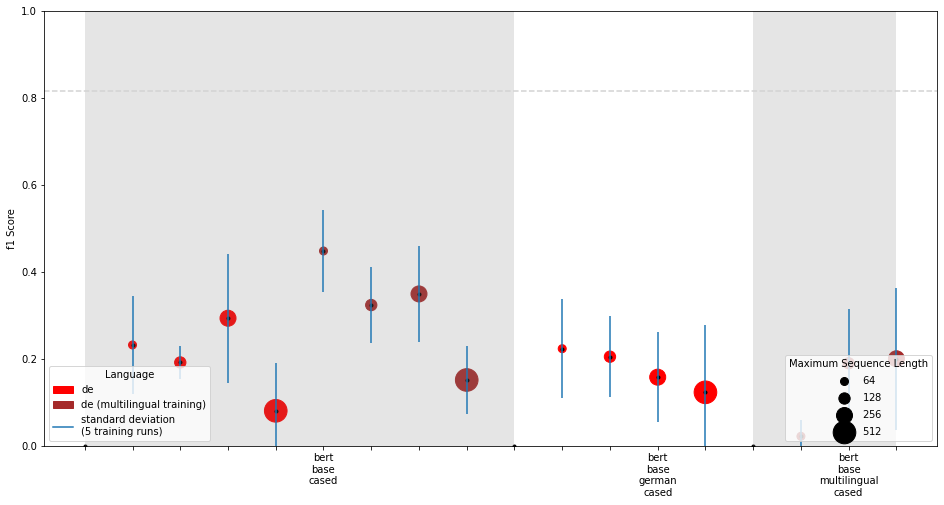

In [ ]:
plot_results(grouped_ne_test, ["de", "multilingual-de"], set="test", score="f1")

In [ ]:
global_sent_metrics = get_global_sent_metrics(sent_test_metrics, sent_dev_metrics)
global_sent_metrics.head()

,model,max_sequence_length,epochs,suffix,language,run,set,label,precision,recall,f1,support
0,bert_base_cased,128,3,_run_de_1,de,1,dev,0,0.6471,0.4783,0.5500,23
1,bert_base_cased,128,3,_run_de_1,de,1,dev,1,0.9883,0.9941,0.9912,1022
2,bert_base_cased,128,3,_run_de_1,de,1,dev,accuracy,0.9828,0.9828,0.9828,1045
3,bert_base_cased,128,3,_run_de_1,de,1,dev,macro_avg,0.8177,0.7362,0.7706,1045
0,bert_base_cased,128,3,_run_de_1,de,1,test,0,0.7442,0.6400,0.6882,50


In [ ]:
sent_test = global_sent_metrics[(global_sent_metrics["set"] == "test") &
                                (global_sent_metrics["label"].isin(["0", "1", "accuracy", "macro_avg"]))]
grouped_sent_test = sent_test.groupby(["model", "language", "max_sequence_length", "label"]).agg({"run": "count", "f1": [np.mean, np.std]}).reset_index()
grouped_sent_test

model language max_sequence_length  \
                                                                           
0                           bert_base_cased       de                  64   
1                           bert_base_cased       de                  64   
2                           bert_base_cased       de                  64   
3                           bert_base_cased       de                  64   
4                           bert_base_cased       de                 128   
..                                      ...      ...                 ...   
115  dbmdz_bert_base_french_europeana_cased       fr                 256   
116  dbmdz_bert_base_french_europeana_cased       fr                 512   
117  dbmdz_bert_base_french_europeana_cased       fr                 512   
118  dbmdz_bert_base_french_europeana_cased       fr                 512   
119  dbmdz_bert_base_french_europeana_cased       fr                 512   

         label   run       f1            
               count     mean       std  
0            0     5  0.74864  0.023812  
1            1     5  0.98832  0.000896  
2     accuracy     5  0.97770  0.001751  
3    macro_avg     5  0.86850  0.012365  
4            0     5  0.71044  0.045718  
..         ...   ...      ...       ...  
115  macro_avg     5  0.86394  0.014053  
116          0     5  0.64214  0.104705  
117          1     5  0.98474  0.003612  
118   accuracy     5  0.97070  0.006927  
119  macro_avg     5  0.81344  0.054145  

[120 rows x 7 columns]

In [ ]:
grouped_sent_test[grouped_sent_test["language"].isin(["de", "multilingual-de"])]

model         language max_sequence_length  \
                                                                        
0                bert_base_cased               de                  64   
1                bert_base_cased               de                  64   
2                bert_base_cased               de                  64   
3                bert_base_cased               de                  64   
4                bert_base_cased               de                 128   
5                bert_base_cased               de                 128   
6                bert_base_cased               de                 128   
7                bert_base_cased               de                 128   
8                bert_base_cased               de                 256   
9                bert_base_cased               de                 256   
10               bert_base_cased               de                 256   
11               bert_base_cased               de                 256   
12               bert_base_cased               de                 512   
13               bert_base_cased               de                 512   
14               bert_base_cased               de                 512   
15               bert_base_cased               de                 512   
32               bert_base_cased  multilingual-de                  64   
33               bert_base_cased  multilingual-de                  64   
34               bert_base_cased  multilingual-de                  64   
35               bert_base_cased  multilingual-de                  64   
36               bert_base_cased  multilingual-de                 128   
37               bert_base_cased  multilingual-de                 128   
38               bert_base_cased  multilingual-de                 128   
39               bert_base_cased  multilingual-de                 128   
40               bert_base_cased  multilingual-de                 256   
41               bert_base_cased  multilingual-de                 256   
42               bert_base_cased  multilingual-de                 256   
43               bert_base_cased  multilingual-de                 256   
44               bert_base_cased  multilingual-de                 512   
45               bert_base_cased  multilingual-de                 512   
46               bert_base_cased  multilingual-de                 512   
47               bert_base_cased  multilingual-de                 512   
64        bert_base_german_cased               de                  64   
65        bert_base_german_cased               de                  64   
66        bert_base_german_cased               de                  64   
67        bert_base_german_cased               de                  64   
68        bert_base_german_cased               de                 128   
69        bert_base_german_cased               de                 128   
70        bert_base_german_cased               de                 128   
71        bert_base_german_cased               de                 128   
72        bert_base_german_cased               de                 256   
73        bert_base_german_cased               de                 256   
74        bert_base_german_cased               de                 256   
75        bert_base_german_cased               de                 256   
76        bert_base_german_cased               de                 512   
77        bert_base_german_cased               de                 512   
78        bert_base_german_cased               de                 512   
79        bert_base_german_cased               de                 512   
80  bert_base_multilingual_cased  multilingual-de                  64   
81  bert_base_multilingual_cased  multilingual-de                  64   
82  bert_base_multilingual_cased  multilingual-de                  64   
83  bert_base_multilingual_cased  multilingual-de                  64   
84  bert_base_multilingual_cased  multilingual-de                 128   
85  bert_bas

c:\Users\Lea\Documents\Uni Aachen\5. Semester\Master Thesis\own-code\notebooks\helpersParsingResults.py:441: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(n_x, rotation=0, rotation_mode='anchor', ha="center") #rotation=75


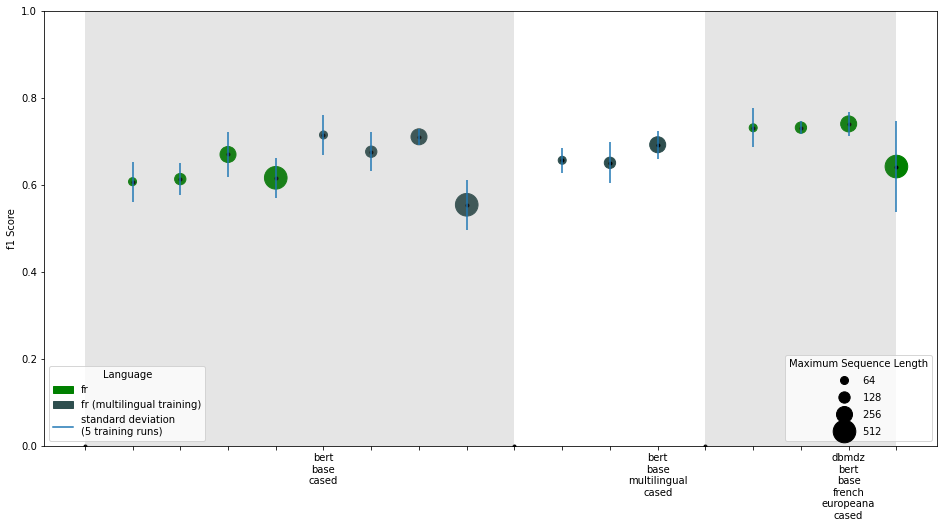

In [ ]:
plot_results(grouped_sent_test[grouped_sent_test["label"]=="0"], ["fr", "multilingual-fr"], add_baseline=False)

c:\Users\Lea\Documents\Uni Aachen\5. Semester\Master Thesis\own-code\notebooks\helpersParsingResults.py:441: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(n_x, rotation=0, rotation_mode='anchor', ha="center") #rotation=75


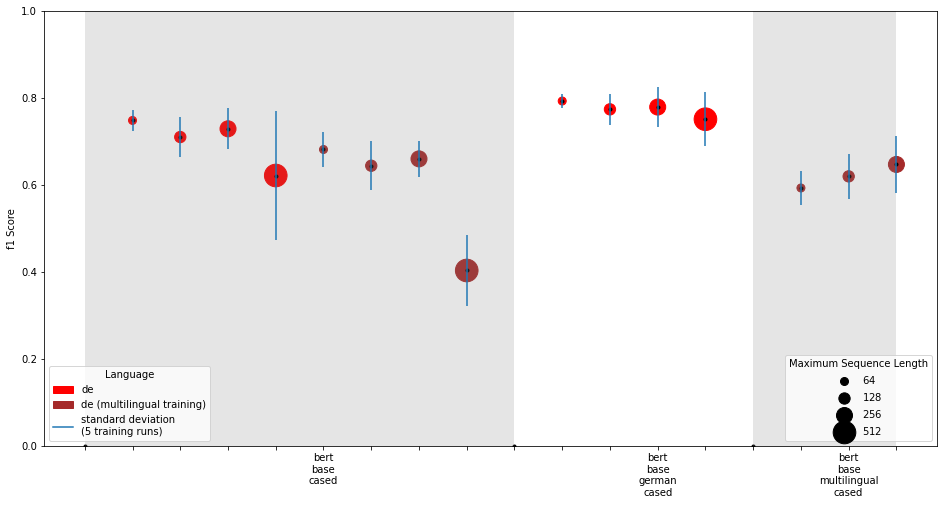

In [ ]:
plot_results(grouped_sent_test[grouped_sent_test["label"]=="0"], ["de", "multilingual-de"], add_baseline=False)

In [143]:
grouped_sent_test[grouped_sent_test["model"]=="dbmdz_bert_base_french_europeana_cased"]

model language max_sequence_length  \
                                                                           
104  dbmdz_bert_base_french_europeana_cased       fr                  64   
105  dbmdz_bert_base_french_europeana_cased       fr                  64   
106  dbmdz_bert_base_french_europeana_cased       fr                  64   
107  dbmdz_bert_base_french_europeana_cased       fr                  64   
108  dbmdz_bert_base_french_europeana_cased       fr                 128   
109  dbmdz_bert_base_french_europeana_cased       fr                 128   
110  dbmdz_bert_base_french_europeana_cased       fr                 128   
111  dbmdz_bert_base_french_europeana_cased       fr                 128   
112  dbmdz_bert_base_french_europeana_cased       fr                 256   
113  dbmdz_bert_base_french_europeana_cased       fr                 256   
114  dbmdz_bert_base_french_europeana_cased       fr                 256   
115  dbmdz_bert_base_french_europeana_cased       fr                 256   
116  dbmdz_bert_base_french_europeana_cased       fr                 512   
117  dbmdz_bert_base_french_europeana_cased       fr                 512   
118  dbmdz_bert_base_french_europeana_cased       fr                 512   
119  dbmdz_bert_base_french_europeana_cased       fr                 512   

         label   run       f1            
               count     mean       std  
104          0     5  0.73128  0.044470  
105          1     5  0.98778  0.001579  
106   accuracy     5  0.97660  0.003063  
107  macro_avg     5  0.85952  0.023042  
108          0     5  0.73160  0.015466  
109          1     5  0.98738  0.000746  
110   accuracy     5  0.97590  0.001384  
111  macro_avg     5  0.85948  0.008065  
112          0     5  0.74018  0.027031  
113          1     5  0.98776  0.001041  
114   accuracy     5  0.97662  0.001990  
115  macro_avg     5  0.86394  0.014053  
116          0     5  0.64214  0.104705  
117          1     5  0.98474  0.003612  
118   accuracy     5  0.97070  0.006927  
119  macro_avg     5  0.81344  0.054145

In [144]:
grouped_sent_test[grouped_sent_test["model"]=="bert_base_german_cased"]

model language max_sequence_length      label   run  \
                                                                   count   
64  bert_base_german_cased       de                  64          0     5   
65  bert_base_german_cased       de                  64          1     5   
66  bert_base_german_cased       de                  64   accuracy     5   
67  bert_base_german_cased       de                  64  macro_avg     5   
68  bert_base_german_cased       de                 128          0     5   
69  bert_base_german_cased       de                 128          1     5   
70  bert_base_german_cased       de                 128   accuracy     5   
71  bert_base_german_cased       de                 128  macro_avg     5   
72  bert_base_german_cased       de                 256          0     5   
73  bert_base_german_cased       de                 256          1     5   
74  bert_base_german_cased       de                 256   accuracy     5   
75  bert_base_german_cased       de                 256  macro_avg     5   
76  bert_base_german_cased       de                 512          0     5   
77  bert_base_german_cased       de                 512          1     5   
78  bert_base_german_cased       de                 512   accuracy     5   
79  bert_base_german_cased       de                 512  macro_avg     5   

         f1            
       mean       std  
64  0.79326  0.015693  
65  0.98998  0.000559  
66  0.98088  0.001062  
67  0.89160  0.008108  
68  0.77416  0.034933  
69  0.98970  0.001247  
70  0.98032  0.002397  
71  0.88194  0.018042  
72  0.77940  0.045146  
73  0.98970  0.001748  
74  0.98032  0.003339  
75  0.88452  0.023436  
76  0.75142  0.061802  
77  0.98896  0.001746  
78  0.97884  0.003442  
79  0.87018  0.031760

In [ ]:
newag_pred_dir = "./../data/experiments_newag/"
newag_true_dir = "./../data/release/2_new_ag/"

newag_true_files = {"de": {"dev": "de/newsagency-data-2-dev-de_newags.tsv", 
                     "test": "de/newsagency-data-2-test-de_newags.tsv"},
              "fr": {"dev": "fr/newsagency-data-2-dev-fr_newags.tsv", 
                     "test": "fr/newsagency-data-2-test-fr_newags.tsv"}
}

newag_pred_files = {
    "de": {"dev": "newsagency-data-2-dev-de_newags_pred.tsv", 
           "test": "newsagency-data-2-test-de_newags_pred.tsv"},
    "fr": {"dev": "newsagency-data-2-dev-fr_newags_pred.tsv", 
           "test": "newsagency-data-2-test-fr_newags_pred.tsv"}
}

In [ ]:
df_best_newag = get_all_best_model_runs(newag_pred_dir)
df_best_newag.head()

Was not able to get results for model: model_bert_base_multilingual_cased_max_sequence_length_256_epochs_3_run_multilingual_4


C:\Users\Lea\AppData\Local\Temp/ipykernel_20244/1632665863.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["name"] = df["model"] + "_" + df["max_sequence_length"].astype(str) + "_" + df["language"] + "_" + set
C:\Users\Lea\AppData\Local\Temp/ipykernel_20244/1632665863.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["lang"] = df["language"].apply(lambda x: "multilingual" if "multi" in x else x)
C:\Users\Lea\AppData\Local\Temp/ipykernel_20244/1632665863.py:9: SettingWithCopyWarning: 
A value is 

,index,model,max_sequence_length,epochs,suffix,set,language,run,loss,precision,recall,f1,name,lang,modelname
0,1,bert_base_cased,128,3,_run_de_1,test,de,1,0.151960,0.263158,0.196078,0.224719,bert_base_cased_128_de_test,de,model_bert_base_cased_max_sequence_length_128_...
4,19,bert_base_cased,128,3,_run_fr_5,test,fr,5,0.182115,0.337079,0.196078,0.247934,bert_base_cased_128_fr_test,fr,model_bert_base_cased_max_sequence_length_128_...
0,21,bert_base_cased,128,3,_run_multilingual-de_1,test,multilingual-de,1,0.175955,0.593750,0.372549,0.457831,bert_base_cased_128_multilingual-de_test,multilingual,model_bert_base_cased_max_sequence_length_128_...
0,23,bert_base_cased,128,3,_run_multilingual-fr_1,test,multilingual-fr,1,0.177693,0.512500,0.267974,0.351931,bert_base_cased_128_multilingual-fr_test,multilingual,model_bert_base_cased_max_sequence_length_128_...
2,45,bert_base_cased,256,3,_run_de_3,test,de,3,0.123417,0.583333,0.396226,0.471910,bert_base_cased_256_de_test,de,model_bert_base_cased_max_sequence_length_256_...


In [ ]:
imported_newag_models = {}
for i, row in df_best_newag.iterrows():
    if "multilingual" in row["language"]:
        lang = row["language"][-2:]
    else:
        lang = row["language"]
    imported_newag_models[row["name"]] = parse_tsv_gt_and_prediction(row["modelname"], row["set"], lang, 
                                                                     newag_true_dir, newag_true_files, newag_pred_dir, newag_pred_files)


In [ ]:
for model, model_df in imported_newag_models.items():
    print(f"{model} - % of correctly predicted news agencies:\n{get_correct_ratios(model_df)}\n")

bert_base_cased_128_de_test - % of correctly predicted news agencies:
{'at_beginning': 0.0, 'in_middle': 30.56, 'at_end': None}

bert_base_cased_128_fr_test - % of correctly predicted news agencies:
{'at_beginning': 0.0, 'in_middle': 29.49, 'at_end': 66.67}

bert_base_cased_128_multilingual-de_test - % of correctly predicted news agencies:
{'at_beginning': 100.0, 'in_middle': 56.25, 'at_end': None}

bert_base_cased_128_multilingual-fr_test - % of correctly predicted news agencies:
{'at_beginning': 100.0, 'in_middle': 50.0, 'at_end': 100.0}

bert_base_cased_256_de_test - % of correctly predicted news agencies:
{'at_beginning': 100.0, 'in_middle': 62.86, 'at_end': None}

bert_base_cased_256_fr_test - % of correctly predicted news agencies:
{'at_beginning': 50.0, 'in_middle': 32.79, 'at_end': 66.67}

bert_base_cased_256_multilingual-de_test - % of correctly predicted news agencies:
{'at_beginning': 100.0, 'in_middle': 53.66, 'at_end': None}

bert_base_cased_256_multilingual-fr_test - % of

[]

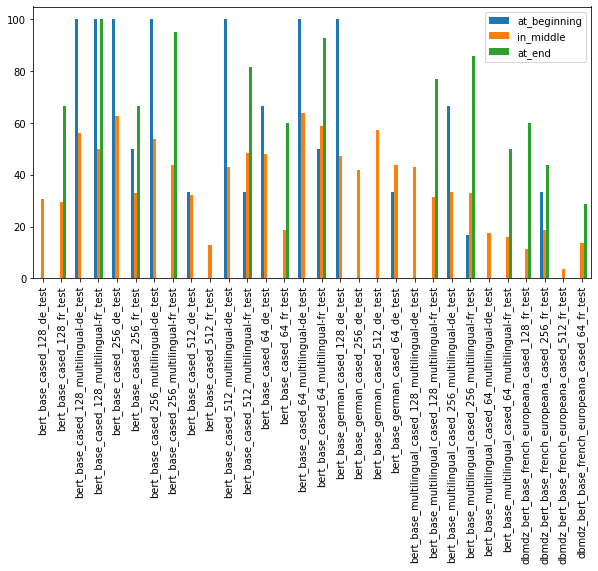

In [ ]:
df_pos_newag = get_all_df_pos(imported_newag_models)

fig, ax = plt.subplots(figsize=(10, 5))
df_pos_newag.plot.bar(ax=ax)
ax.set_xticklabels(df_pos_newag["model"])
plt.plot()

In [ ]:
imported_newag_models["bert_base_cased_128_de_test"].head(20)

,token,pred_ag,true_ag,pos_in_doc,len_doc,LED,is_correct_class,at_beginning,at_end,in_middle
0,Canadian,O,unk,23.0,1225.0,0.0,False,False,False,True
1,Press,O,unk,24.0,1225.0,0.0,False,False,False,True
2,PA,AP,unk,459.0,1225.0,0.0,False,False,False,True
3,SPT,unk,unk,536.0,1225.0,0.0,True,False,False,True
4,Canadian,unk,unk,672.0,1225.0,0.0,True,False,False,True
5,Press,UP-UPI,unk,673.0,1225.0,0.0,False,False,False,True
6,CAPA,unk,unk,742.0,1225.0,0.0,True,False,False,True
7,Fides,O,unk,842.0,1225.0,0.0,False,False,False,True
8,AGERPRESS,O,unk,925.0,1225.0,0.0,False,False,False,True
9,NTB,DNB,unk,993.0,1225.0,0.0,False,False,False,True


In [ ]:
imported_newag_models["bert_base_cased_128_fr_test"].sum()

token               AgencedeConstantinopleAgencetélégraphiqueottom...
pred_ag             ATS-SDAOOATS-SDAATS-SDAOOarticleauthorATS-SDAO...
true_ag             unkunkunkunkunkunkunkunkunkunkunkunkunkunkunku...
pos_in_doc                                                    93174.0
len_doc                                                      174240.0
LED                                                               0.0
is_correct_class                                                   31
at_beginning                                                       15
at_end                                                             25
in_middle                                                         178
dtype: object

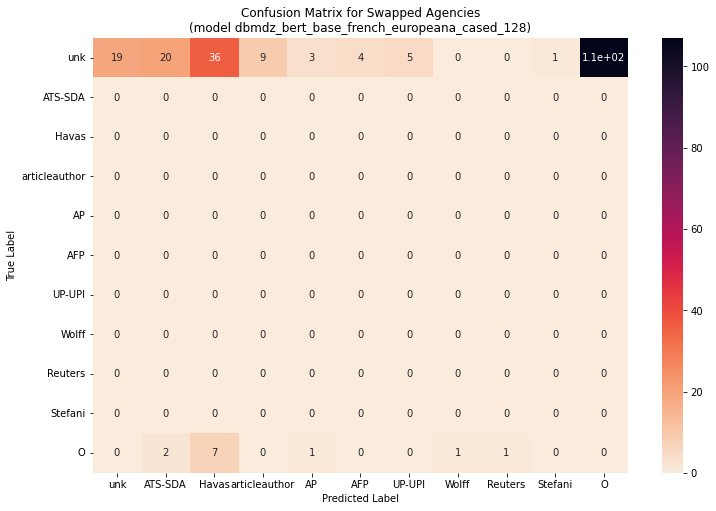

In [141]:
plot_confusion_matrix(imported_newag_models["dbmdz_bert_base_french_europeana_cased_128_fr_test"], "Confusion Matrix for Swapped Agencies\n(model dbmdz_bert_base_french_europeana_cased_128)")

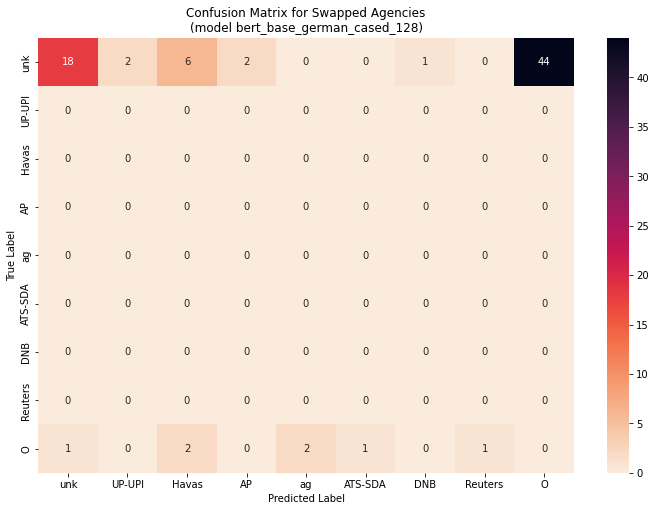

In [133]:
plot_confusion_matrix(imported_newag_models["bert_base_german_cased_128_de_test"], "Confusion Matrix for Swapped Agencies\n(model bert_base_german_cased_128)")